In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary config/cache directory at /jobfs/116014514.gadi-pbs/matplotlib-jgvqbbg7 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=2) #n_workers=2
# Scale the client to have n workers workers
# client.cluster.scale(28)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:42693
 -   dashboard at:        /proxy/40433/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:43733'
 -         Start Nanny at: 'tcp://127.0.0.1:39221'
 - Register worker <WorkerState 'tcp://127.0.0.1:43241', name: 0, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:43241
 - Starting established connection to tcp://127.0.0.1:33282
 - Register worker <WorkerState 'tcp://127.0.0.1:38999', name: 1, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:38999
 - Starting established connection to tcp://127.0.0.1:33272
 - Receive client connection: Client-f381245a-15c2-11ef-b47c-000007a6fe80
 - Starting established connection to tcp://127.0.0.1:33296


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40433/status,
Dashboard: /proxy/40433/status,Workers: 2
Total threads: 2,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42693,Workers: 2
Dashboard: /proxy/40433/status,Total threads: 2
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:43241,Total threads: 1
Dashboard: /proxy/43315/status,Memory: 125.59 GiB
Nanny: tcp://127.0.0.1:43733,


In [4]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [5]:
best_ds_raw = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)

best_ds_raw['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds_raw.time.values))
best_ds = best_ds_raw.copy(deep=True)['temperature']
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [6]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [7]:
base_period_ds_count = base_period_ds.count(dim='time')

In [8]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [9]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [10]:
# Resetting the anomlies to 1850
best_ds = best_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

# Sample Calculation

In [11]:
selection_dict = dict(lat=-38, lon=145, method='nearest')

In [13]:
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [nan, ..., nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [20]:
base_arr = base_period_ds.sel(**selection_dict).squeeze().values

In [87]:
arr_best =  best_ds.sel(**selection_dict).squeeze()
arr_best = arr_best.isel(time=slice(130, 160))

In [88]:
np.take(arr_best.time.values, [0, -1])

array([cftime.DatetimeGregorian(1980, 12, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2009, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [89]:
arr_best = arr_best.values

In [90]:
np.min(arr_best), np.nanmin(base_arr)

(-0.25295871, -0.43993783)

In [91]:
np.max(arr_best), np.nanmax(base_arr)

(1.6317903, 0.6432928)

In [92]:
bins = np.arange(-1, 1.7, 0.1)

In [93]:
def get_rel_freq(arr, bins):
    counts, _ = np.histogram(arr, bins=bins, density=False)
    rel_freq = counts/len(arr)
    return rel_freq

In [94]:
rel_freq_base = get_rel_freq(base_arr, bins)
rel_freq_best = get_rel_freq(arr_best, bins)

<function matplotlib.pyplot.show(close=None, block=None)>

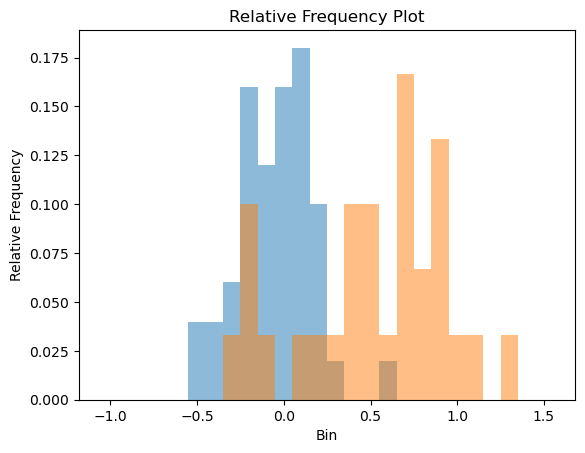

In [95]:

# plot the relative frequency
plt.bar(bins[:-1], rel_freq_base, alpha=0.5, width=0.1)
plt.bar(bins[:-1], rel_freq_best, alpha=0.5, width=0.1)

plt.xlabel('Bin')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Plot')
# plt.xticks(range(len(rel_freq)), ['[0, 2)', '[2, 4)', '[4, 6)'])
plt.show

In [103]:
freq_stack = np.vstack([rel_freq_base, rel_freq_best])
freq_stack.shape

(2, 26)

In [107]:
freq_min = np.nanmin(freq_stack, axis=0)
freq_min.shape

(26,)

In [108]:
freq_min_sum_percent = np.sum(freq_min) * 100

In [109]:
freq_min_sum_percent

27.333333333333332